# IMDB sentiment prediction with pytorch

I'm reading the material in the keras book but implementing in pytorch.

I'm using [polarity data set v2.0](https://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz) to predict binary: positive or negative review. The data uncompressed it looks like:

```
data/review_polarity/txt_sentoken/
├── neg
│   ├── cv000_29416.txt
│   ├── cv001_19502.txt
│   ├── cv002_17424.txt
│   ├── cv003_12683.txt
│   ├── cv004_12641.txt
...
```

Instead of trying to learn the ancillary package torchtext, I'm going to use SpaCy to tokenize.

## Support code

In [1]:
import codecs
import os
import re
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def filelist(root):
    """Return a fully-qualified list of filenames under root directory; sort names alphabetically."""
    allfiles = []
    for path, subdirs, files in os.walk(root):
        for name in files:
            allfiles.append(os.path.join(path, name))
    return sorted(allfiles)

def get_text(filename:str):
    """
    Load and return the text of a text file, assuming latin-1 encoding as that
    is what the BBC corpus uses.  Use codecs.open() function not open().
    """
    f = codecs.open(filename, encoding='latin-1', mode='r')
    s = f.read()
    f.close()
    return s

def load_docs(docs_dirname:str):
    """
    Load all .txt files under docs_dirname and return a list of doc strings, one per doc.
    Ignore empty and non ".txt" files.
    """
    docs = []
    for filename in filelist(docs_dirname):#[0:600]:
        if not filename.endswith(".txt"): continue
        # print(f"Process {filename}")
        filetext = get_text(filename)
        if len(filetext)==0: continue
        docs.append( compress_whitespace(filetext) )
    return docs

def words(text:str):
    """
    Given a string, return a list of words normalized as follows.
    Split the string to make words first by using regex compile() function
    and string.punctuation + '0-9\\r\\t\\n]' to replace all those
    char with a space character.
    Split on space to get word list.
    Ignore words < 3 char long.
    Lowercase all words
    Remove English stop words
    """
    ctrl_chars = '\x00-\x1f'
    regex = re.compile(r'[' + ctrl_chars + string.punctuation + '0-9\r\t\n]')
    nopunct = regex.sub(" ", text)  # delete stuff but leave at least a space to avoid clumping together
    words = nopunct.split(" ")
    words = [w for w in words if len(w) > 2]  # ignore a, an, to, at, be, ...
    words = [w.lower() for w in words]
    words = [w for w in words if w not in ENGLISH_STOP_WORDS]
    return words

def compress_whitespace(s): # collapse things like "\n   \t  " with " "
    return re.sub(r"(\s+)", ' ', s)

In [202]:
def train_test_split(X, y, test_size:float):
    n = len(X)
    shuffle_idx = np.random.permutation(range(n))
    X = X[shuffle_idx]
    y = y[shuffle_idx]
    n_valid = int(n*test_size)
    n_train = n - n_valid
    X_train, X_valid = X[0:n_train], X[n_train:]
    y_train, y_valid = y[0:n_train], y[n_train:]
    return X_train, X_valid, y_train, y_valid

In [421]:
import matplotlib.pyplot as plt
def plot_history(history, yrange=(0.0, 5.00), figsize=(3.5,3)):
    plt.figure(figsize=figsize)
    plt.ylabel("Sentiment log loss")
    plt.xlabel("Epochs")
    loss = history[:,0]
    valid_loss = history[:,1]
    plt.plot(loss, label='train_loss')
    plt.plot(valid_loss, label='val_loss')
    # plt.xlim(0, 200)
    plt.ylim(*yrange)
    plt.legend(loc='lower right')
    plt.show()

In [422]:
import torch
def pad(a, w):
    return torch.cat([a, a.new_zeros(w - a.shape[0])])

## Load movie reviews

In [ ]:
# paperspace needs this
!pip -q install spacy
!python -m spacy download en_core_web_sm

In [423]:
import spacy

In [424]:
neg_dirname = "data/review_polarity/txt_sentoken/neg"
pos_dirname = "data/review_polarity/txt_sentoken/pos"
negdocs = load_docs(neg_dirname)
posdocs = load_docs(pos_dirname)
n_negdocs = len(negdocs)
n_posdocs = len(posdocs)
n_negdocs, n_posdocs

(1000, 1000)

In [425]:
nlp = en_core_web_sm.load()
# The following fails on paperspace gradient platform
#nlp = spacy.load("en_core_web_sm") # When I use plain English() it doesn't seem to give POS info

In [426]:
#neg_tokenized = [list(nlp(d)) for d in negdocs] # super slow!
#pos_tokenized = [list(nlp(d)) for d in posdocs]

neg_tokenized = [words(d) for d in negdocs] # much faster!
pos_tokenized = [words(d) for d in posdocs]

In [427]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import numpy as np

ndocprefix = 20 # use first 20 words
vocab_size = 10_000
all = []
for tokens in neg_tokenized + pos_tokenized:
    all.extend([w for w in tokens])
c = Counter(all)
V = c.most_common(vocab_size)
V = sorted(word_to_idx.keys())
word_to_idx = {w:i for i,w in enumerate(V)}

In [428]:
# Keep only words in V, just first 20, convert to ints in word_to_idx
neg = []
pos = []
for i in range(len(neg_tokenized)):
    d = [word_to_idx[w] for w in neg_tokenized[i] if w in V][:ndocprefix]
    neg.append( pad(torch.tensor(d), ndocprefix) )
for i in range(len(pos_tokenized)):
    d = [word_to_idx[w] for w in pos_tokenized[i] if w in V][:ndocprefix]
    pos.append( pad(torch.tensor(d), ndocprefix) )

In [429]:
X = torch.stack(neg+pos)
y = torch.tensor([0]*n_negdocs + [1]*n_posdocs).reshape(-1,1)
y = y.float()
X.shape, y.shape

(torch.Size([2000, 20]), torch.Size([2000, 1]))

## Build simple sentiment learner / predictor

The keras book uses 8 dimensional embedding vectors, 20 word prefix for each document,
10,000 most common words. They concatenate the 20 8-vectors and run that into a
single-neuron final layer. That surprises me. I tried adding a hidden layer but 
it didn't help very much. Actually, now that I play with it, epochs=150,                      learning_rate=0.03, weight_decay=0.00001, it looks like it starts to consistently get better to about 56% accuracy.

In [442]:
import torch
import torch.nn as nn

"""

"""
class Sentiment(nn.Module):
    def __init__(self, vocab_size, nfactors):
        super(Sentiment, self).__init__()
        self.embedding = nn.Embedding(vocab_size, nfactors)
        self.layers = nn.Sequential(
#             nn.Linear(ndocprefix*nfactors,128), # 128 neurons (Keras book go straight to the last layer!)
#             nn.ReLU(),
            nn.Linear(ndocprefix*nfactors,1)
        )
        
    def forward(self, x):
#         print(x.shape)      # [800, 20]
        output = self.embedding(x)
#         print(output.shape) # [800, 20, 64] = (samples, num word features, embedding dim)
        # must cat the 20 64-vectors together
        output = output.view((x.shape[0], -1))
#         print(output.shape) # [800, 1280]
        output = self.layers(output)
#         print(output.shape) # [800, 1]
        return torch.sigmoid(output)

In [434]:
from sklearn.metrics import accuracy_score

def train(model, X, y, epochs=350, test_size=0.20, learning_rate = 0.002, weight_decay=1.e-4, print_every=30, loss_fn=nn.BCELoss()):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, 0.20)
    print(f"{len(X_train)} training and {len(X_valid)} test records")

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    history = []
    for t in range(epochs):
        y_prob = model(X_train)
        loss = loss_fn(y_prob, y_train)
        y_pred = torch.round(y_prob)

        optimizer.zero_grad()
        loss.backward() # autograd computes U.grad and M.grad
        optimizer.step()
        
        with torch.no_grad():
            loss_valid = loss_fn(model(X_valid), y_valid)
            accur_train = accuracy_score(torch.round(model(X_train)), y_train)
            accur_valid = accuracy_score(torch.round(model(X_valid)), y_valid)

        history.append( (loss, loss_valid) )
        if t % print_every == 0:
            print(f"Epoch {t:3d} log loss {loss:7.3f}, {loss_valid:7.3f}   accuracy {accur_train:4.3f}, {accur_valid:4.3f}")        

    history = torch.tensor(history)
    return model, history

/Users/parrt/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


1600 training and 400 test records
Epoch   0 log loss   0.725,   0.721   accuracy 0.568, 0.517
Epoch  10 log loss   0.599,   0.825   accuracy 0.684, 0.477
Epoch  20 log loss   0.476,   0.869   accuracy 0.792, 0.495
Epoch  30 log loss   0.292,   1.017   accuracy 0.925, 0.527
Epoch  40 log loss   0.140,   1.193   accuracy 0.999, 0.507
Epoch  50 log loss   0.083,   1.260   accuracy 1.000, 0.520
Epoch  60 log loss   0.067,   1.214   accuracy 1.000, 0.520
Epoch  70 log loss   0.059,   1.148   accuracy 1.000, 0.540
Epoch  80 log loss   0.054,   1.096   accuracy 1.000, 0.560
Epoch  90 log loss   0.052,   1.055   accuracy 1.000, 0.565


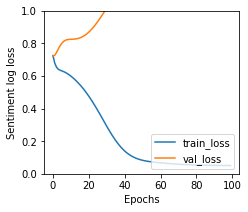

In [448]:
nfactors = 8
model = Sentiment(vocab_size, nfactors)
model, history = train(model, torch.tensor(X), torch.tensor(y),
                       epochs=100,
                       learning_rate=0.03,
                       weight_decay=0.001,
                       print_every=10)

plot_history(history, yrange=(0,1.0))

That's not very good. Depending on where it initializes, I've seen it get to 60% accuracy.

## Add mini-batches

It sounds like many batches of around 32 are sort of the general recommendation to get stochastic gradient descent. See [stackoverflow](https://datascience.stackexchange.com/questions/16807/why-mini-batch-size-is-better-than-one-single-batch-with-all-training-data) and [Revisiting Small Batch Training for Deep Neural Networks](https://arxiv.org/abs/1804.07612).  It seems like training on the whole batch is not done for two reasons:

1.  it has to all fit in GPU memory
2.  the full batch does not add any bouncing around to the gradient descent process which gets us stuck in local minima.



In [454]:
def train(model, X, y,
          epochs=350,
          test_size=0.20,
          learning_rate = 0.002,
          batch_size=32,
          weight_decay=1.e-4,
          loss_fn=nn.BCELoss(),
          print_every=30):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, 0.20)
    print(f"{len(X_train)} training and {len(X_valid)} test records")

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    history = []

    for t in range(epochs): # epochs
        permutation = torch.randperm(X_train.shape[0])

        for k in range(0, X_train.shape[0], batch_size): # mini-batch
            batch_indices = permutation[k:k+batch_size]
            batch_x, batch_y = X_train[batch_indices], y_train[batch_indices]
    
            y_prob = model(X_train)
            loss = loss_fn(y_prob, y_train)
            y_pred = torch.round(y_prob)

            optimizer.zero_grad()
            loss.backward() # autograd computes U.grad and M.grad
            optimizer.step()
        
        with torch.no_grad():
            loss_valid = loss_fn(model(X_valid), y_valid)
            accur_train = accuracy_score(torch.round(model(X_train)), y_train)
            accur_valid = accuracy_score(torch.round(model(X_valid)), y_valid)

        history.append( (loss, loss_valid) )
        if t % print_every == 0:
            print(f"Epoch {t:3d} log loss {loss:7.3f}, {loss_valid:7.3f}   accuracy {accur_train:4.3f}, {accur_valid:4.3f}")        

    history = torch.tensor(history)
    return model, history

In [457]:
nfactors = 8
model = Sentiment(vocab_size, nfactors)
model, history = train(model, torch.tensor(X), torch.tensor(y),
                       epochs=100,
                       learning_rate=0.1,
                       batch_size=32,
                       weight_decay=0.001,
                       print_every=10)

plot_history(history, yrange=(0,1.0))

/Users/parrt/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


1600 training and 400 test records
Epoch   0 log loss   0.011,   1.665   accuracy 1.000, 0.580
Epoch  10 log loss   0.005,   1.667   accuracy 1.000, 0.578
Epoch  20 log loss   0.005,   1.599   accuracy 1.000, 0.540
Epoch  30 log loss   0.005,   1.571   accuracy 1.000, 0.547


KeyboardInterrupt: 

Great! Now I'm getting much closer to 61% just through mini batch training.

## Add more layers and dropout

In [376]:
import torch
import torch.nn as nn

layer1 = 300
layer2 = 32
class SentimentRegularized(nn.Module):
    def __init__(self, vocab_size, nfactors):
        super(SentimentRegularized, self).__init__()
        self.embedding = nn.Embedding(vocab_size, nfactors)
        self.layers = nn.Sequential(
            nn.Linear(ndocprefix*nfactors,layer1), # 300 neurons
            nn.BatchNorm1d(layer1),
#             nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(in_features=layer1, out_features=layer2),
            nn.BatchNorm1d(layer2),
            nn.Dropout(p=0.3),
            nn.ReLU(),
            nn.Linear(32,1)
        )
        
    def forward(self, x):
        output = self.embedding(x)
        output = output.view((x.shape[0], -1))
        output = self.layers(output)
        return torch.sigmoid(output)

/Users/parrt/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


1600 training and 400 test records
Epoch   0 log loss   0.754,   0.723   accuracy 0.795, 0.520
Epoch  10 log loss   0.096,   1.191   accuracy 1.000, 0.512
Epoch  20 log loss   0.018,   1.738   accuracy 1.000, 0.515
Epoch  30 log loss   0.007,   2.195   accuracy 1.000, 0.510
Epoch  40 log loss   0.003,   2.438   accuracy 1.000, 0.510
Epoch  50 log loss   0.003,   2.601   accuracy 1.000, 0.525
Epoch  60 log loss   0.002,   2.855   accuracy 1.000, 0.535
Epoch  70 log loss   0.002,   2.778   accuracy 1.000, 0.532
Epoch  80 log loss   0.002,   2.787   accuracy 1.000, 0.532
Epoch  90 log loss   0.001,   3.389   accuracy 1.000, 0.527


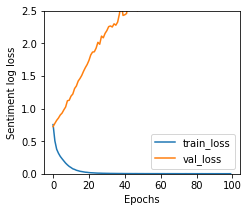

In [392]:
nfactors = 64
model = SentimentRegularized(vocab_size, nfactors)
model, history = train(model, torch.tensor(X), torch.tensor(y),
                       epochs=100,
                       learning_rate=0.01,
                       weight_decay=0.0001,
                       print_every=10)

plot_history(history, yrange=(0,2.5))

Wow. unable to get above about 56% validation accuracy. Try playing with nfactors

/Users/parrt/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


1600 training and 400 test records
Epoch   0 log loss   0.758,   0.688   accuracy 0.684, 0.557
Epoch  10 log loss   0.016,   1.864   accuracy 1.000, 0.585
Epoch  20 log loss   0.001,   4.151   accuracy 1.000, 0.578
Epoch  30 log loss   0.000,   5.575   accuracy 1.000, 0.580
Epoch  40 log loss   0.000,   5.969   accuracy 1.000, 0.578
Epoch  50 log loss   0.000,   7.091   accuracy 1.000, 0.578
Epoch  60 log loss   0.000,   7.179   accuracy 1.000, 0.590
Epoch  70 log loss   0.000,   7.196   accuracy 1.000, 0.580
Epoch  80 log loss   0.000,   7.689   accuracy 1.000, 0.588
Epoch  90 log loss   0.000,   7.618   accuracy 1.000, 0.578


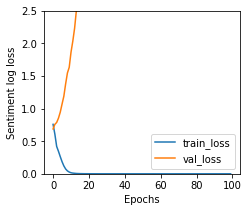

In [397]:
nfactors = 128
model = SentimentRegularized(vocab_size, nfactors)
model, history = train(model, torch.tensor(X), torch.tensor(y),
                       epochs=100,
                       learning_rate=0.03,
                       weight_decay=0.000001,
                       print_every=10)

plot_history(history, yrange=(0,2.5))

In [387]:
y_pred = torch.round(model(X))
accur = (y_pred==y).sum().item() / len(y)
accur

0.9165

## Try RF

Can't get much above 50% accurate as expected from raw text.

In [417]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 0.20)
rf = RandomForestClassifier(n_estimators=200, oob_score=True, n_jobs=-1)
rf.fit(X_train, y_train)
print(rf.oob_score_)
accuracy_score(rf.predict(X_valid), y_valid)

/Users/parrt/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


0.53625


0.5525